In [1]:
%matplotlib inline
from copy import deepcopy as copy
import json
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from replay import smln, analysis, plot

cc = np.concatenate


LOAD_PRFX = 'PARAM_SWEEP_RESULTS'
SAVE_PRFX = 'PARAM_SWEEP_RESULTS_EXT'

# model
M_PARAMS = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 3000,
    'W_PC_PC': .026, 'L_PC_PC': 0.053, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'R_MAX': 20, 'L_PL': .15,
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.005, 'E_L_INH': -0.06, 'V_TH_INH': -0.05, 'V_R_INH': -0.06, 'T_R_INH': 0.002,
    
    # Inh. architecture
    'N_INH': 300,  # unused
    'W_INH_PC': 0.003, 'W_PC_INH': 0.0002,
    
    # gating inputs
    'W_PC_G': 0.008216, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 125, 
    
    # potentiation
    'SGM_MAX': 2, 'B_SGM': 1, 'R_SGM': 10
}

# simulation
S_PARAMS = {
    "RNG_SEED": None,
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "X_TRG": 1, "Y_TRG": -0.75,
    
    'SPD': 0.2, 'TRJ': [(-1, .75), (0, .75), (0, -.75), (1, -.75)],
    
    'TRG': [
        {'T': 0.15, 'A': 0.02, 'R': 0.3, 'D': 0.002, 'X': 1, 'Y': -0.75},
    ],
    
    "schedule": {"D_SMLN": .6},
}

# ANALYSIS
A_PARAMS = {
    'MIN_START': 0.1,  # s
    'SMOOTH_FR': 4,  # 2 ms
    'MIN_GAP_DUR': .01,  # s
    'MIN_EVT_DUR': .03,  # s
    'EVT_DTCN_TH': 0.5,  # Hz
    'POS_T_CORR_TH': 0.85,  # correlation
    'SPEED_CALC_TRNC_FRAC': 0.1,  # fraction
    'MIN_DUR_SPD_CALC': 0.05,  # s
    'MAX_DUR_SPD_CALC': 0.4,  # s
    'MIN_ONE_WAY_EVTS_SPD_CALC': 5,
    'SPD_CALC_TRNC_FRAC': 0.1,  # fraction
    'FR_NTRJ_MIN_BLOWUP': 1.5,  # Hz
    'FR_NTRJ_TRJ_BLOWUP_RATIO': .3,  # frac
    'SPD_CALC_MAX_ITER': 20,
    'N_SPD_CALC_TRIALS': 10,
    'SPD_CALC_START_OFFSET': 0.015,  # s
}

## Test replay speed calculation

Running smln...
Smln complete.


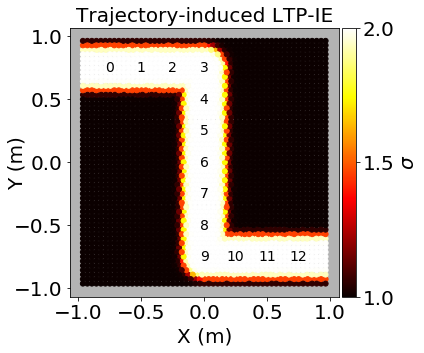

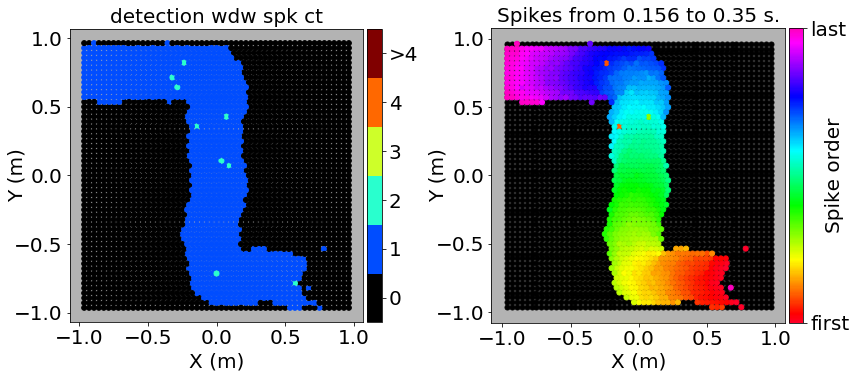

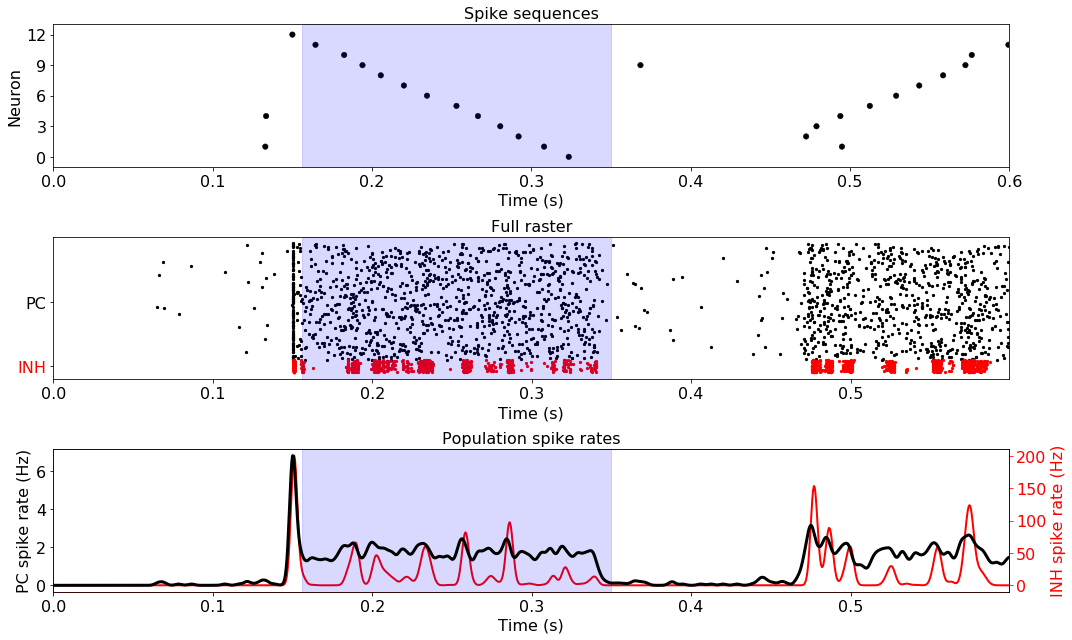

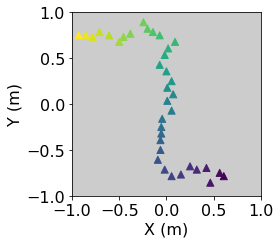

In [2]:
# run smln
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

s_params['RNG_SEED'] = 0

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

# make plots
XYS_RASTER = [
    (-.75, .75), (-.5, .75), (-.25, .75), (0, .75),
    (0, .5), (0, .25), (0, 0), (0, -.25), (0, -.5),
    (0, -.75), (.25, -.75), (.5, -.75), (.75, -.75)
]
EPOCHS = [(.156, .35)]

## potentiation profile
ax, c_ax = plot.ltp_ie_profile(rslt)

## add PC labels
for ctr, (x, y) in enumerate(XYS_RASTER):
    ax.text(x, y, str(ctr), fontsize=14, horizontalalignment='center', verticalalignment='center')

## selected replay epoch spike sequences
for epoch in EPOCHS:
    fig, axs = plot.spike_seq(rslt, epoch=epoch)

## raster for selected PCs
fig, axs = plot.raster_with_pc_inh(
    rslt,
    XYS_RASTER,
    colors=np.zeros(len(XYS_RASTER)),
    cmap='inferno',
    nearest=1,
    epoch=(0, .6),
    trg_plt=[],
    y_lim=(-1, 13),
    y_ticks=[0, 3, 6, 9, 12],
    smoothness=4)

## shade selected replay epochs
for epoch in EPOCHS:
    axs[0].axvspan(*epoch, color='b', alpha=0.15)
    axs[1].axvspan(*epoch, color='b', alpha=0.15)
    axs[2].axvspan(*epoch, color='b', alpha=0.15)
    
## plot decoded trajectories during replay epochs
axs = plt.subplots(1, len(EPOCHS), figsize=(len(EPOCHS)*4, 3.5), tight_layout=True, squeeze=False)[1][0]
for epoch, ax in zip(EPOCHS, axs):
    t, xy = analysis.decode_trj(rslt, epoch[0], epoch[1], .005, min_spks_wdw=10)
    plot.decoded_trj(ax, rslt, t, xy);

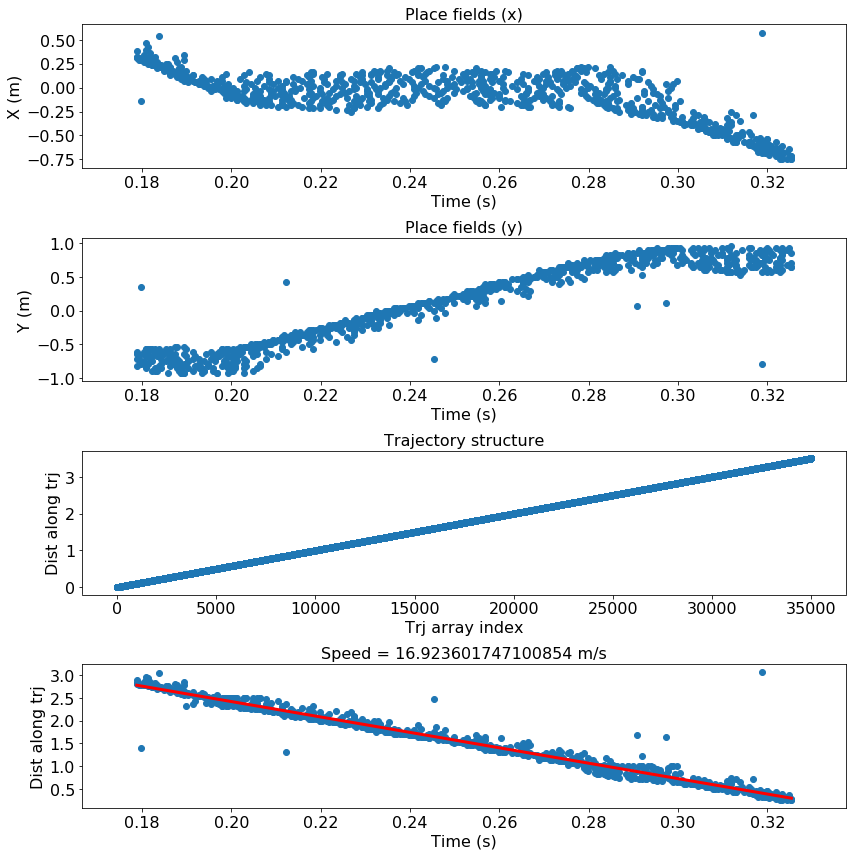

In [3]:
# test spd calc
starts, ends = analysis.get_evts(rslt, A_PARAMS)

start = starts[0] + 0.015
end = ends[0]

spd, debug = analysis.calc_spd(rslt, start, end, A_PARAMS, debug=True)
pfxs_spk = debug['pfxs_spk']
pfys_spk = debug['pfys_spk']
ds_trj_spk = debug['ds_trj_spk']
ts_spk = debug['ts_spk']

slp = debug['slp']
icpt = debug['icpt']

# plot xs and ys vs spike time
fig, axs = plt.subplots(4, 1, figsize=(12, 12), tight_layout=True)
axs[0].scatter(ts_spk, pfxs_spk)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('X (m)')
axs[0].set_title('Place fields (x)')

axs[1].scatter(ts_spk, pfys_spk)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Y (m)')
axs[1].set_title('Place fields (y)')

axs[2].scatter(np.arange(len(debug['d_trj'])), debug['d_trj'])
axs[2].set_xlabel('Trj array index')
axs[2].set_ylabel('Dist along trj')
axs[2].set_title('Trajectory structure')

# scatter
axs[3].scatter(ts_spk, ds_trj_spk)
# line
x_line = np.array([ts_spk[0], ts_spk[-1]])
y_line = slp*x_line + icpt
axs[3].plot(x_line, y_line, c='r', lw=3)

axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Dist along trj')
axs[3].set_title('Speed = {} m/s'.format(spd))

for ax in axs:
    set_font_size(ax, 16)

# Param sweep

In [4]:
def spd_calc_sweep(sfx, a_params):
    """Calculate virtual speeds of replay events given existing parameter sweep file."""
    
    # load existing param sweep results into dataframe
    df, rslts, header_ = analysis.make_df('{}_{}'.format(LOAD_PRFX, sfx))
    
    # write header of new save file
    with open('{}_{}'.format(SAVE_PRFX, sfx), 'w') as f:
        header = {
            'SWEEP_PARAMS': header_['sweep_params'],
            'M_PARAMS': header_['m_params'],
            'S_PARAMS': header_['s_params'],
            'A_PARAMS': a_params,
        }
        f.write(json.dumps(header) + '\n\n')
    
    # get model and smln params
    m_params = copy(header['M_PARAMS'])
    s_params = copy(header['S_PARAMS'])
    
    # set trigger and short smln dur for speed calc reruns
    s_params['TRG'] = [{'T': 0.15, 'A': 0.01, 'R': 0.2, 'D': 0.002, 'X': 1, 'Y': -0.75}]
    s_params['schedule']['D_SMLN'] = 0.6
    offset = a_params['SPD_CALC_START_OFFSET']
    
    # id all smln_ids w/o blowup
    cond_0_blowup = df['FR_NTRJ'] >= a_params['FR_NTRJ_MIN_BLOWUP']
    cond_1_blowup = (df['FR_NTRJ']/df['FR_TRJ']) >= a_params['FR_NTRJ_TRJ_BLOWUP_RATIO']
    no_blowup = ~(cond_0_blowup | cond_1_blowup)
    
    df_rerun = df[no_blowup]
    
    # loop through valid smlns and rerun
    for ctr, (smln_id, row) in enumerate(df_rerun.iterrows()):
            
        print('Rerunning smln # {}/{}: SMLN_ID {}'.format(ctr, len(df_rerun), smln_id))
        
        # set variable params for this smln
        params_varied = {param: row[param] for param in header['SWEEP_PARAMS']['VARY']}
        for param, param_val in params_varied.items():
            m_params[param] = param_val
            
        # loop over short trials for calculating speeds
        spds = {}
        durs = {}
        
        for tr_ctr in range(a_params['SPD_CALC_MAX_ITER']):
            sys.stdout.write('.')
            
            # run smln with new rng_seed
            rng_seed = np.random.randint(0, 1000)
            s_params['RNG_SEED'] = rng_seed
            
            rslt = smln.run(m_params, s_params)
            
            # check for event in proper time window
            starts, ends = analysis.get_evts(rslt, a_params)

            for start_, end_ in zip(starts, ends):
                if s_params['TRG'][0]['T'] - .01 <= start_ < s_params['TRG'][0]['T'] + .02:
                    start = start_
                    end = end_
                    break
            else:
                continue
            
            # if evt is sufficiently long, calc speed
            if a_params['MIN_DUR_SPD_CALC'] <= (end - start - offset) < a_params['MAX_DUR_SPD_CALC']:
                durs[rng_seed] = end - start
                spds[rng_seed] = analysis.calc_spd(rslt, start + offset, end, a_params)
            else:
                continue
                
            if len(spds) >= a_params['N_SPD_CALC_TRIALS']:
                break
                
        print('')
        
        # curate re-run results
        save_dict = {
            'SMLN_ID': smln_id,
            'PARAMS': copy(params_varied),
            'SPDS': copy(spds),
            'DURS': copy(durs),
        }
        
        # append results to save file
        with open('{}_{}'.format(SAVE_PRFX, sfx), 'a') as f:
            f.write(json.dumps(save_dict) + '\n')

### SWEEP 0: W_PC_PC vs L_PC_PC

In [5]:
spd_calc_sweep('0_W_PC_PC_L_PC_PC.txt', A_PARAMS)

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Rerunning smln # 0/336: SMLN_ID 0
....................
Rerunning smln # 1/336: SMLN_ID 1
....................
Rerunning smln # 2/336: SMLN_ID 2
....................
Rerunning smln # 3/336: SMLN_ID 3
....................
Rerunning smln # 4/336: SMLN_ID 4
....................
Rerunning smln # 5/336: SMLN_ID 5
....................
Rerunning smln # 6/336: SMLN_ID 6
....................
Rerunning smln # 7/336: SMLN_ID 7
....................
Rerunning smln # 8/336: SMLN_ID 8
....................
Rerunning smln # 9/336: SMLN_ID 9
....................
Rerunning smln # 10/336: SMLN_ID 10
....................
Rerunning smln # 11/336: SMLN_ID 11
....................
Rerunning smln # 12/336: SMLN_ID 12
....................
Rerunning smln # 13/336: SMLN_ID 13
....................
Rerunning smln # 14/336: SMLN_ID 14
..............
Rerunning smln # 15/336: SMLN_ID 15
.............
Rerunning smln # 16/336: SMLN_ID 16
.............
Rerunning smln # 17/336: SMLN_ID 17
...........
Rerunning smln # 18/336

............
Rerunning smln # 298/336: SMLN_ID 361
..............
Rerunning smln # 299/336: SMLN_ID 362
...............
Rerunning smln # 300/336: SMLN_ID 363
....................
Rerunning smln # 301/336: SMLN_ID 364
....................
Rerunning smln # 302/336: SMLN_ID 365
....................
Rerunning smln # 303/336: SMLN_ID 366
....................
Rerunning smln # 304/336: SMLN_ID 369
....................
Rerunning smln # 305/336: SMLN_ID 378
....................
Rerunning smln # 306/336: SMLN_ID 379
....................
Rerunning smln # 307/336: SMLN_ID 380
..............
Rerunning smln # 308/336: SMLN_ID 381
...........
Rerunning smln # 309/336: SMLN_ID 382
...............
Rerunning smln # 310/336: SMLN_ID 383
....................
Rerunning smln # 311/336: SMLN_ID 384
....................
Rerunning smln # 312/336: SMLN_ID 385
....................
Rerunning smln # 313/336: SMLN_ID 386
....................
Rerunning smln # 314/336: SMLN_ID 387
....................
Rerunning smln 

### SWEEP 1: W_PC_PC vs W_PC_INH

In [5]:
spd_calc_sweep('1_W_PC_PC_W_PC_INH.txt', A_PARAMS)

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Rerunning smln # 0/371: SMLN_ID 0
....................
Rerunning smln # 1/371: SMLN_ID 1
....................
Rerunning smln # 2/371: SMLN_ID 2
.............
Rerunning smln # 3/371: SMLN_ID 3
...........
Rerunning smln # 4/371: SMLN_ID 4
...........
Rerunning smln # 5/371: SMLN_ID 21
....................
Rerunning smln # 6/371: SMLN_ID 22
....................
Rerunning smln # 7/371: SMLN_ID 23
....................
Rerunning smln # 8/371: SMLN_ID 24
............
Rerunning smln # 9/371: SMLN_ID 25
..........
Rerunning smln # 10/371: SMLN_ID 26
...........
Rerunning smln # 11/371: SMLN_ID 27
...........
Rerunning smln # 12/371: SMLN_ID 28
..........
Rerunning smln # 13/371: SMLN_ID 42
....................
Rerunning smln # 14/371: SMLN_ID 43
....................
Rerunning smln # 15/371: SMLN_ID 44
....................
Rerunning smln # 16/371: SMLN_ID 45
............
Rerunning smln # 17/371: SMLN_ID 46
............
Rerunning smln # 18/371: SMLN_ID 47
...........
Rerunning smln # 19/371: SML

....................
Rerunning smln # 294/371: SMLN_ID 364
....................
Rerunning smln # 295/371: SMLN_ID 365
....................
Rerunning smln # 296/371: SMLN_ID 366
....................
Rerunning smln # 297/371: SMLN_ID 367
....................
Rerunning smln # 298/371: SMLN_ID 368
....................
Rerunning smln # 299/371: SMLN_ID 369
....................
Rerunning smln # 300/371: SMLN_ID 370
....................
Rerunning smln # 301/371: SMLN_ID 371
....................
Rerunning smln # 302/371: SMLN_ID 372
....................
Rerunning smln # 303/371: SMLN_ID 373
....................
Rerunning smln # 304/371: SMLN_ID 374
....................
Rerunning smln # 305/371: SMLN_ID 375
....................
Rerunning smln # 306/371: SMLN_ID 376
....................
Rerunning smln # 307/371: SMLN_ID 377
....................
Rerunning smln # 308/371: SMLN_ID 378
....................
Rerunning smln # 309/371: SMLN_ID 379
....................
Rerunning smln # 310/371: SMLN_ID 3